# Introduction and setup

In this notebook, I have code to load in the stellar profiles in 3 dimensions which 
were previously calculated on the command line so that we can plot quantities such as 
the 1D velocity dispersion and evolution with time of the mass.

In [1]:
using LilGuys
using CairoMakie, Arya

In [2]:
using PyFITS

In [3]:
modelsdir = ENV["DWARFS_ROOT"] * "/analysis"

"/cosma/home/durham/dc-boye1/data/dwarfs/analysis"

In [4]:
CairoMakie.activate!(type=:png)

In [5]:
import HDF5

In [6]:
import TOML
obs_props = TOML.parsefile(joinpath(ENV["DWARFS_ROOT"], "observations/sculptor/observed_properties.toml"))

Dict{String, Any} with 50 entries:
  "position_angle"       => 94.0
  "ellipticity"          => 0.37
  "distance_err"         => 2
  "dec_err"              => 0.0007
  "ellipticity_ref"      => "munoz+2018"
  "position_angle_ref"   => "munoz+2018"
  "dec_ref"              => "munoz+2018"
  "radial_velocity_ref"  => "arroyo-polonio+2024"
  "R_h_err"              => 0.04
  "pmdec_err"            => 0.017
  "sigma_v_err"          => 0.2
  "sigma_v"              => 9.7
  "M_L_s"                => 1.7
  "dec"                  => -33.7186
  "M_L_s_err"            => 0.67
  "radial_velocity_err"  => 0.3
  "r_h"                  => 12.33
  "R_h_inner_em"         => 0.26
  "distance_modulus_err" => 0.05
  "R_h_note"             => "sersic fits"
  "distance"             => 83.2
  "r_h_err"              => 0.05
  "Mv_ref"               => "munoz+2018"
  "pmra_err"             => 0.017
  "Mv_err"               => 0.14
  ⋮                      => ⋮

In [7]:
function load_profile(modelname, starsname)
    orbit = load_profiles(modelname * "/stars/" * starsname)

    return orbit
end

load_profile (generic function with 1 method)

In [8]:
function get_t_f(name)
    df = TOML.parsefile("$name/orbital_properties.toml")
    idx_f = df["idx_f"]
    times = HDF5.h5open("$name/centres.hdf5") do f
        return f["times"][:]
    end
    
    return times[idx_f]
end

get_t_f (generic function with 1 method)

In [9]:
function load_isolation(modelname, starsname)
    iso = read_fits(joinpath(modelname * "/../stars", starsname, "stellar_profiles_3d_scalars.fits"))
    return iso
end

load_isolation (generic function with 1 method)

In [31]:
function load_profile(filename, starsname; extension="stellar_profiles_3d_scalars.fits")
    path = joinpath(filename, "stars", starsname, extension)
    
    df = read_fits(path)

    time_f = get_t_f(filename)


    df.time .-= time_f
    return df[df.time .< 0, :]
end

load_profile (generic function with 1 method)

In [11]:
function plot_v_t!(profiles; x_shift = 0, kwargs...)
	sigmas = profiles.sigma_v

    t = profiles.time
	scatterlines!(t * T2GYR .+ x_shift, sigmas * V2KMS; kwargs...)
end

plot_v_t! (generic function with 1 method)

In [12]:
function plot_v_t(profiles; x_shift=0, kwargs...)
	fig, ax = FigAxis(
		xlabel = "time / Gyr",
		ylabel = L"\sigma_v / \textrm{km s^{-1}}";
        kwargs...
	)

    plot_v_t!(profiles, x_shift=x_shift)

    fig
end
    

plot_v_t (generic function with 1 method)

In [13]:
function compare_v_t(profilesi, profs_iso=nothing; x_shifts=zeros(length(profilesi)), legend_position=:lb)
	fig, ax = FigAxis(
		xlabel = "time / Gyr",
		ylabel = L"\sigma_v / \textrm{km s^{-1}}",
	)


    for i in eachindex(profilesi)
        label, profiles = profilesi[i]

        kwargs = Dict{Symbol, Any}()
        kwargs[:label] = label
        kwargs[:color] = COLORS[i]
  
        plot_v_t!(profiles; x_shift=x_shifts[i], kwargs...)
    end

    if profs_iso !== nothing
        for i in eachindex(profs_iso)
            label, profiles = profs_iso[i]
    
      
            sigmas = profiles.sigma_v
    
            t = profiles.time
            t = t .- t[end]
            scatterlines!(t * T2GYR, sigmas * V2KMS, color=COLORS[i])
            
        end
    end
    
    hlines!(obs_props["sigma_v"], color=:grey)
    hspan!(obs_props["sigma_v"] - obs_props["sigma_v_err"], 
        obs_props["sigma_v"] + obs_props["sigma_v_err"],
        color = (:grey, 0.1), label="observed")

    LilGuys.hide_grid!(ax)
    if legend_position == :outside
        Legend(fig[1,2], ax)
    else
        
        axislegend(position=legend_position)
    end
    
	fig
end

compare_v_t (generic function with 2 methods)

In [14]:
function compare_boundmass(profilesi, profs_iso=nothing; x_shifts=zeros(length(profilesi)), legend_position=:lb)
	fig, ax = FigAxis(
		xlabel = "time / Gyr",
		ylabel = "bound stellar mass",
	)


    for i in eachindex(profilesi)
        label, profiles = profilesi[i]

        kwargs = Dict{Symbol, Any}()
        kwargs[:label] = label
        kwargs[:color] = COLORS[i]
        x = profiles.time .+ x_shifts[i]
        y = profiles.bound_mass
        scatter!(x * T2GYR, y; kwargs...)
  
        
    end


    if legend_position == :outside
        Legend(fig[1,2], ax)
    else
        axislegend(position=legend_position)
    end
    
	fig
end

compare_boundmass (generic function with 2 methods)

In [23]:
function load_both(modelnames)
    profs = [key => load_profile(modelname...) for (key, modelname) in modelnames]
    profs_iso = [key => load_isolation(modelname...) for (key, modelname) in modelnames]

    return profs, profs_iso
end

load_both (generic function with 1 method)

# 1e7

### Comparison between orbits

In [15]:
profs = [
    "mean" => load_profile("1e7_V31_r3.2/orbit_mean", "exp2d_rs0.10"),
    "smallperi" => load_profile("1e7_V31_r3.2/orbit_smallperi", "exp2d_rs0.10"),
    "lmc" => load_profile("1e7_V31_r4.2/vasiliev24_L3M11_2x_smallperilmc", "exp2d_rs0.10"),
    ];

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


In [16]:
profs_iso = [
    "mean" => load_isolation("1e7_V31_r3.2/orbit_mean", "exp2d_rs0.10"),
    "smallperi" => load_isolation("1e7_V31_r3.2/orbit_smallperi", "exp2d_rs0.10"),
    "lmc" => load_isolation("1e7_V31_r4.2/vasiliev24_L3M11_2x_smallperilmc", "exp2d_rs0.10"),
];

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


In [17]:
profs_iso[3].second.time * T2GYR

13-element Vector{Float64}:
 0.0
 0.4710948046875
 0.943543330078125
 1.414638134765625
 1.8857329394531248
 2.3568277441406247
 2.82927626953125
 3.3003710742187495
 3.7714658789062496
 4.243914404296874
 4.715009208984375
 5.186104013671875
 5.54484

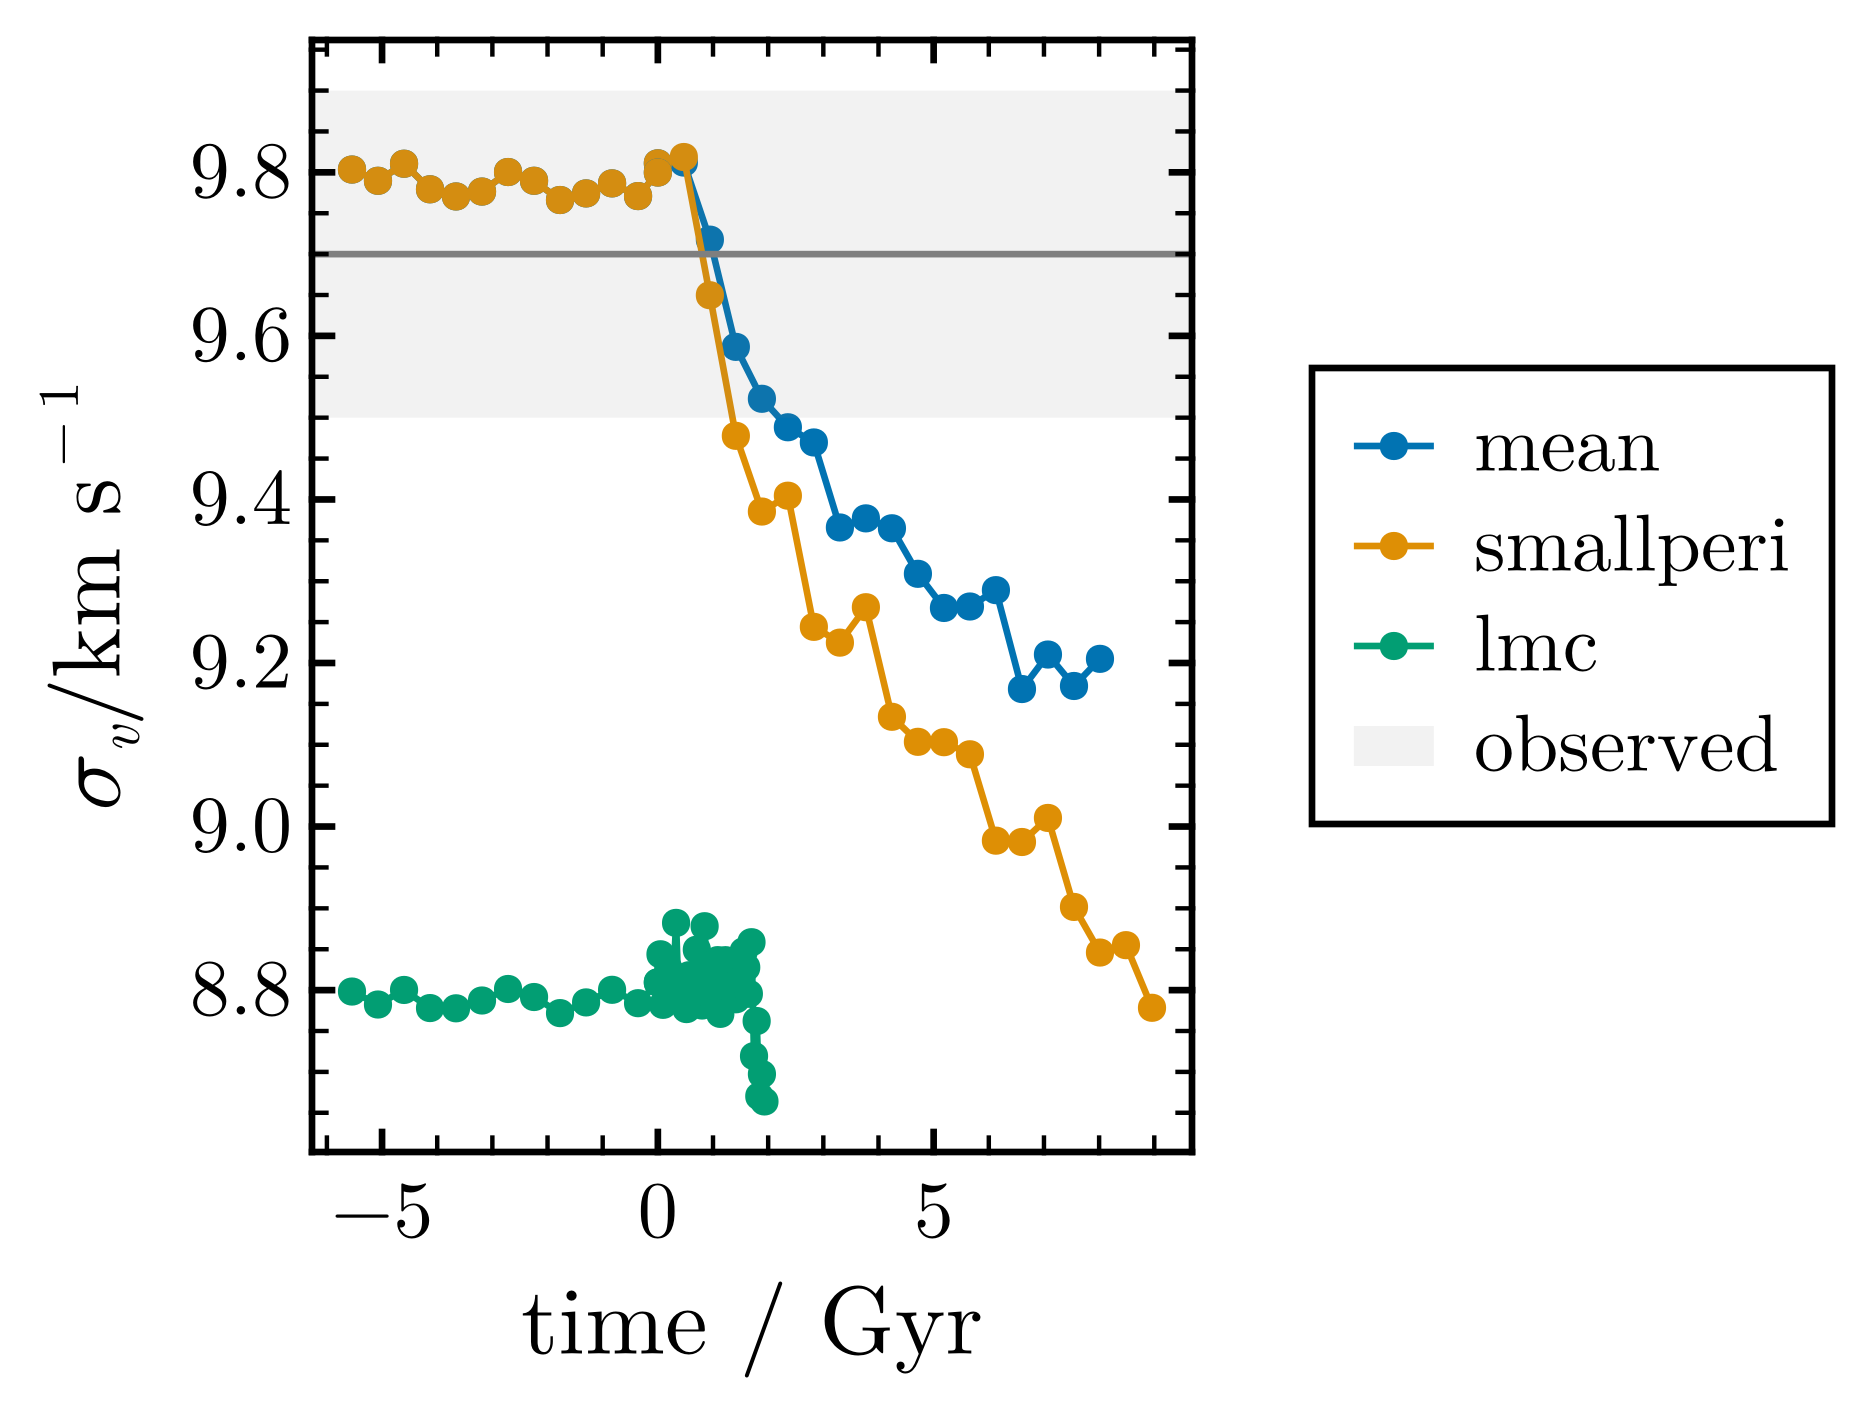

In [18]:
compare_v_t(profs, profs_iso, x_shifts=(0, 0, -T2GYR*profs[3].second.time[1]), legend_position=:outside)

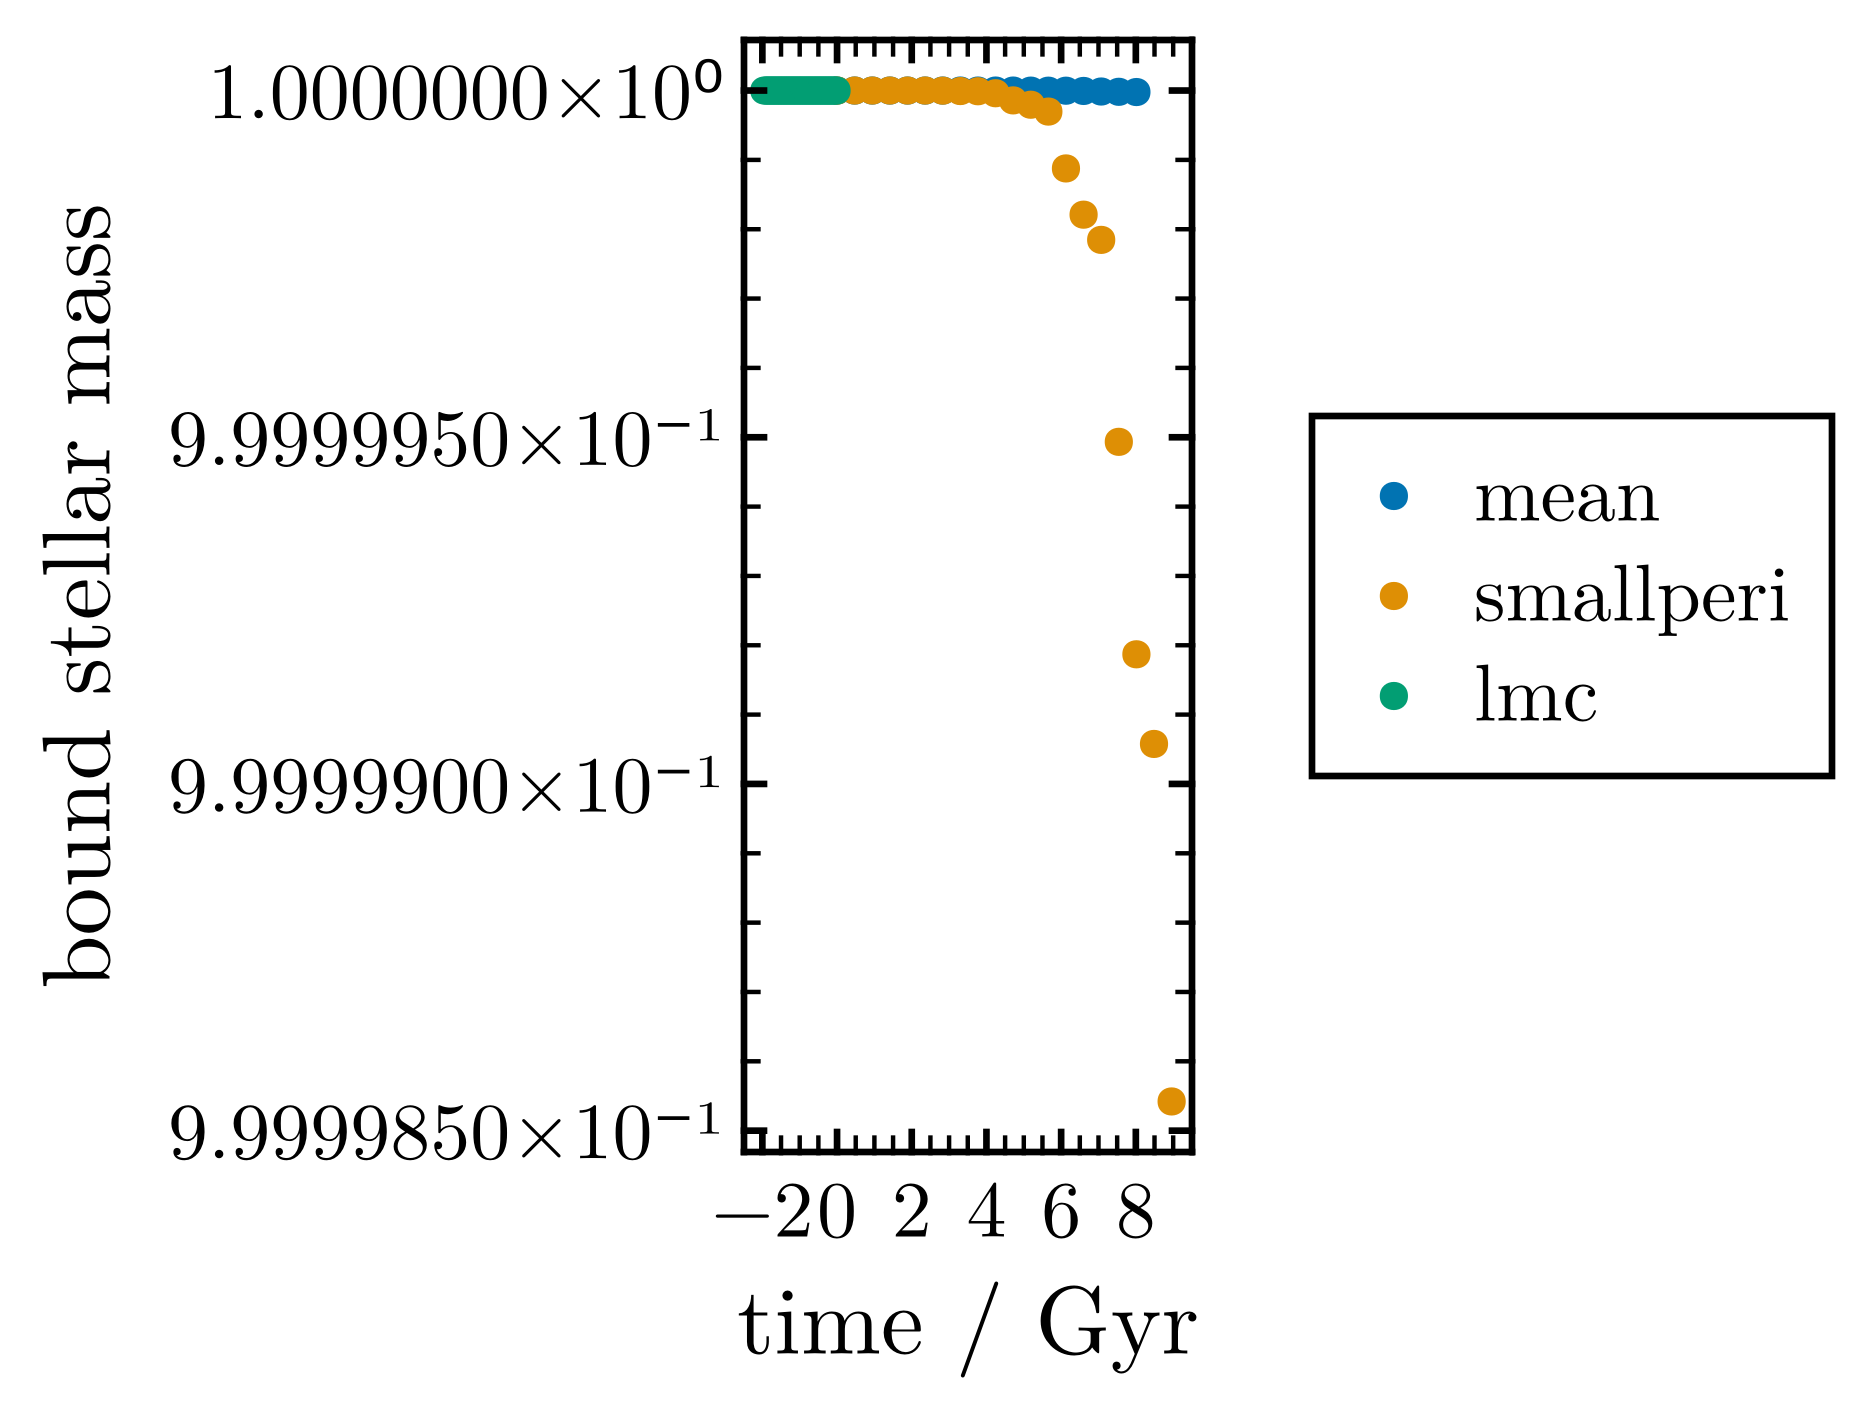

In [19]:
compare_boundmass(profs, x_shifts=(0, 0, -T2GYR*profs[3].second.time[1]), legend_position=:outside)

### Plummer

In [20]:
profs = load_both([
   # "mean" => load_profile("1e7_V31_r3.2/orbit_mean", "plummer_rs0.20"),
    "smallperi" => ("1e7_V31_r3.2/orbit_smallperi", "plummer_rs0.20"),
    "vasiliev" => ("1e7_V31_r4.2/vasiliev24_L3M11_2x_smallperilmc", "plummer_rs0.20"),
    ]
    )

LoadError: Python: FileNotFoundError: [Errno 2] No such file or directory: '1e7_V31_r3.2/orbit_smallperi/stars/plummer_rs0.20/stellar_profiles_3d_scalars.fits'

In [21]:
profs_iso = [
    "mean" => load_isolation("1e7_V31_r3.2/orbit_mean", "plummer_rs0.20"),
    "smallperi" => load_isolation("1e7_V31_r3.2/orbit_smallperi", "plummer_rs0.20"),
    "vasiliev" => load_isolation("1e7_V31_r4.2/vasiliev24_L3M11_2x_smallperilmc", "plummer_rs0.20"),

];

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


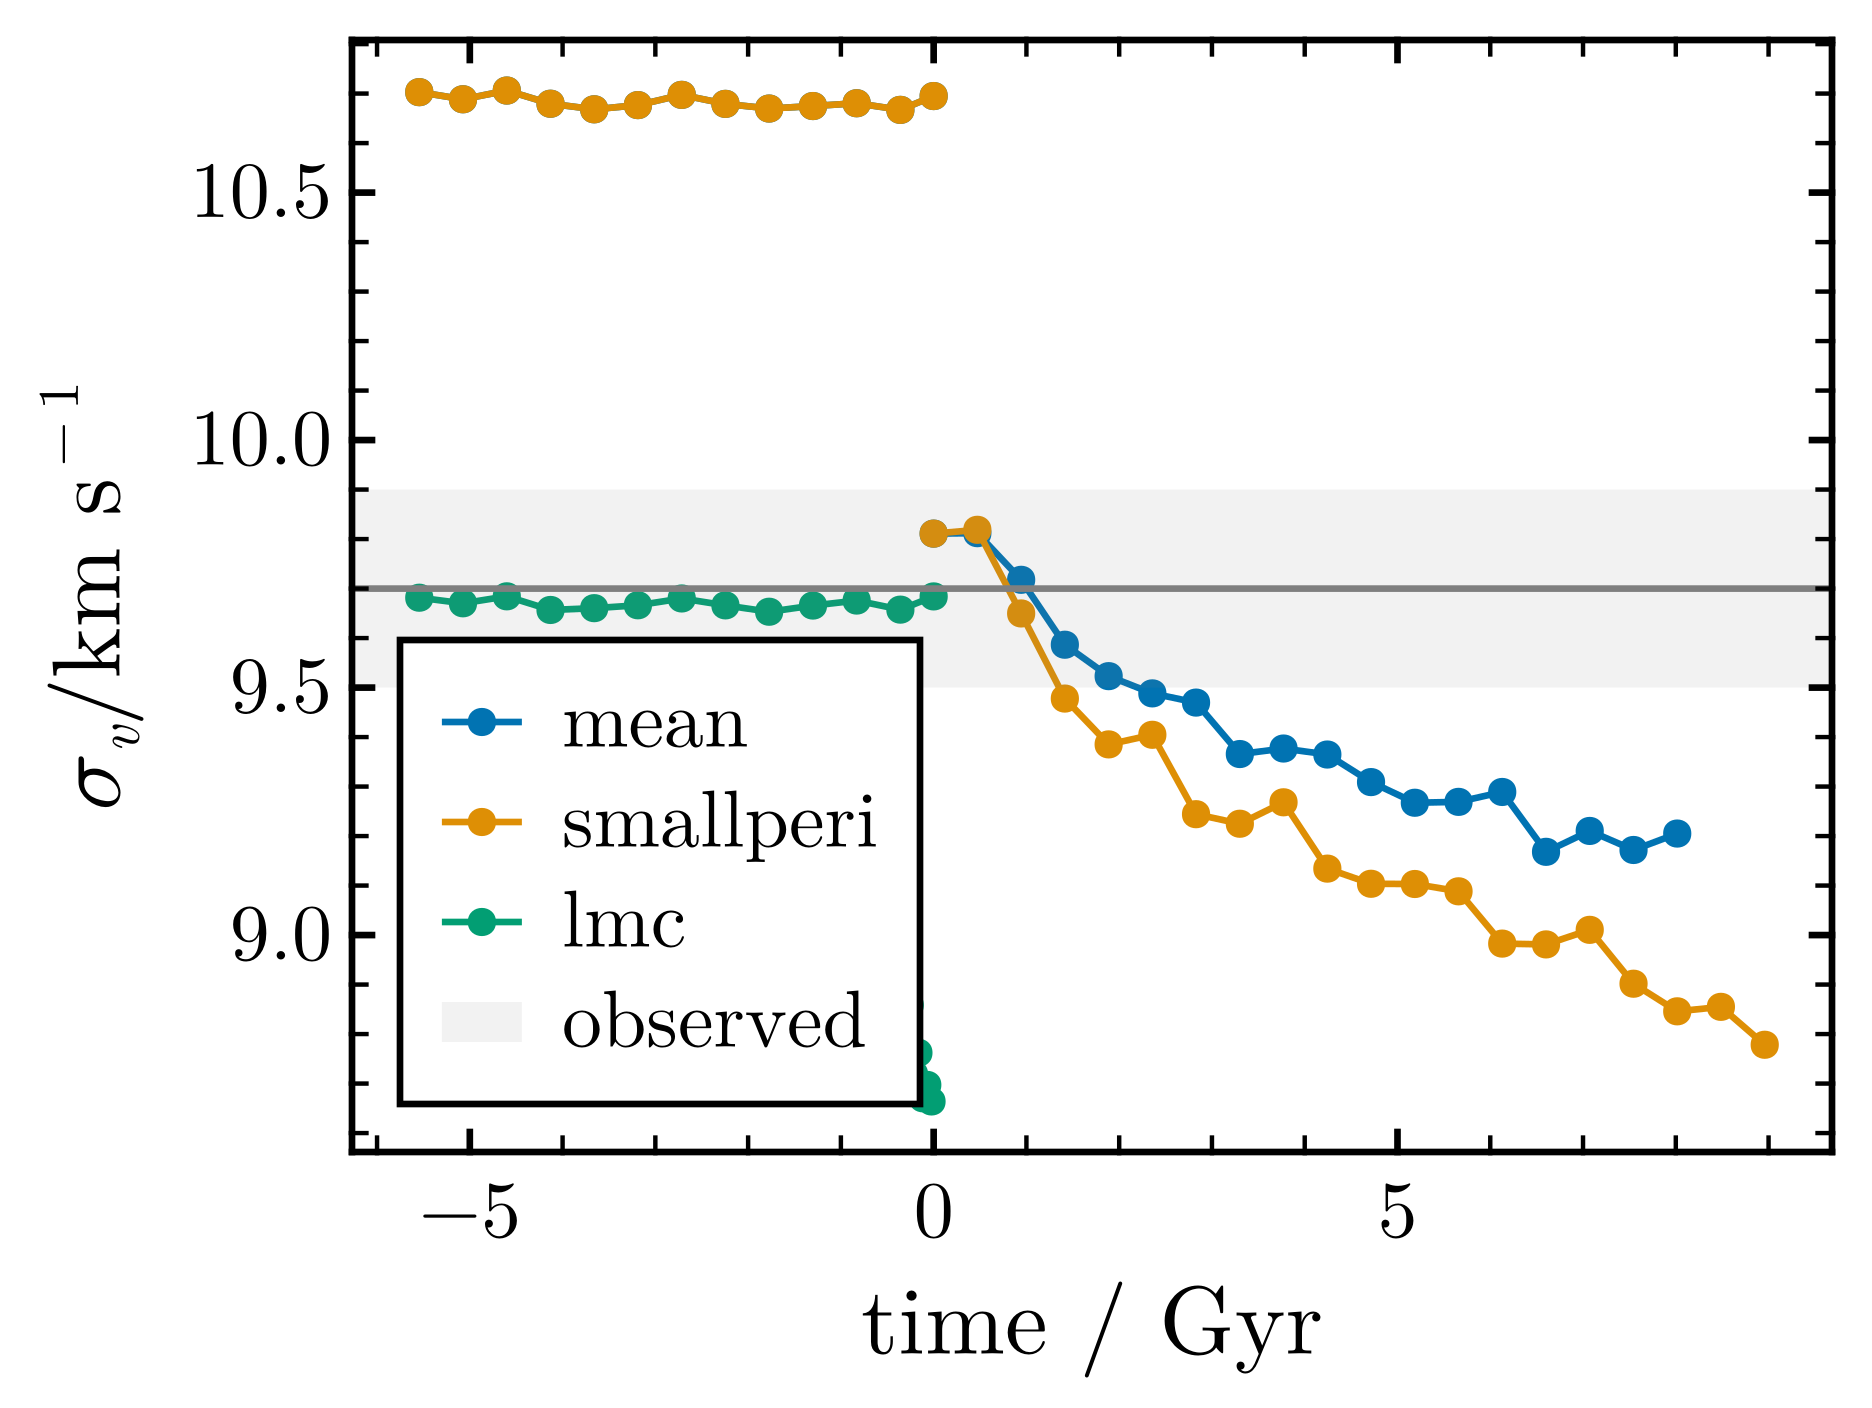

In [22]:
compare_v_t(profs, profs_iso)

In [98]:
compare_boundmass(profs, x_shifts=(0, 0, -T2GYR*profs[3].second.time[1]), legend_position=:outside)

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [3]

## Halo 

In [58]:
profs, profs_iso = load_both(
    ["small" => ("1e6_new_v25_r2.5/orbit_smallperi", "exp2d_rs0.13"),
    "compact" => ("1e6_new_v31_r3.2/orbit_smallperi", "exp2d_rs0.13"),
        ]
    );

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


In [ ]:
compare_v_t(profs, profs_iso, legend_position=:outside)

# Convergence

In [55]:
profs = [
    "1e7" => load_profile("sculptor/1e7_V31_r3.2/orbit_mean", "exp2d_rs0.10"),
     "1e6" => load_profile("sculptor/1e6_V31_r3.2/orbit_mean", "exp2d_rs0.10"),
     "1e5" => load_profile("sculptor/1e5_V31_r3.2/orbit_mean", "exp2d_rs0.10"),
    ];

LoadError: Python: FileNotFoundError: [Errno 2] No such file or directory: 'sculptor/1e7_V31_r3.2/orbit_mean/stars/exp2d_rs0.10/stellar_profiles_3d_scalars.fits'

In [101]:
profs_iso = [
    "mean" => load_isolation("sculptor/1e7_V31_r3.2/orbit_mean", "exp2d_rs0.10"),
    "smallperi" => load_isolation("sculptor/1e7_V31_r3.2/orbit_smallperi", "exp2d_rs0.10"),
    "lmc" => load_isolation("sculptor/1e7_V31_r4.2/vasiliev24_L3M11_2x_smallperilmc", "exp2d_rs0.10"),

];

LoadError: Python: FileNotFoundError: [Errno 2] No such file or directory: 'sculptor/1e7_V31_r3.2/orbit_mean/../stars/exp2d_rs0.10/stellar_profiles_3d_scalars.fits'

In [102]:
compare_v_t(profs, profs_iso, x_shifts=(0, 0, -T2GYR*profs[3].second.time[1]))

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [3]

In [47]:
profs, profs_iso = load_both(
    ["smallperi" => ("1e7_V31_r3.2/orbit_smallperi", "exp2d_rs0.13"),
    "2" => ("1e6_new_v31_r3.2/orbit_smallperi", "exp2d_rs0.13"),
        ]
    );

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


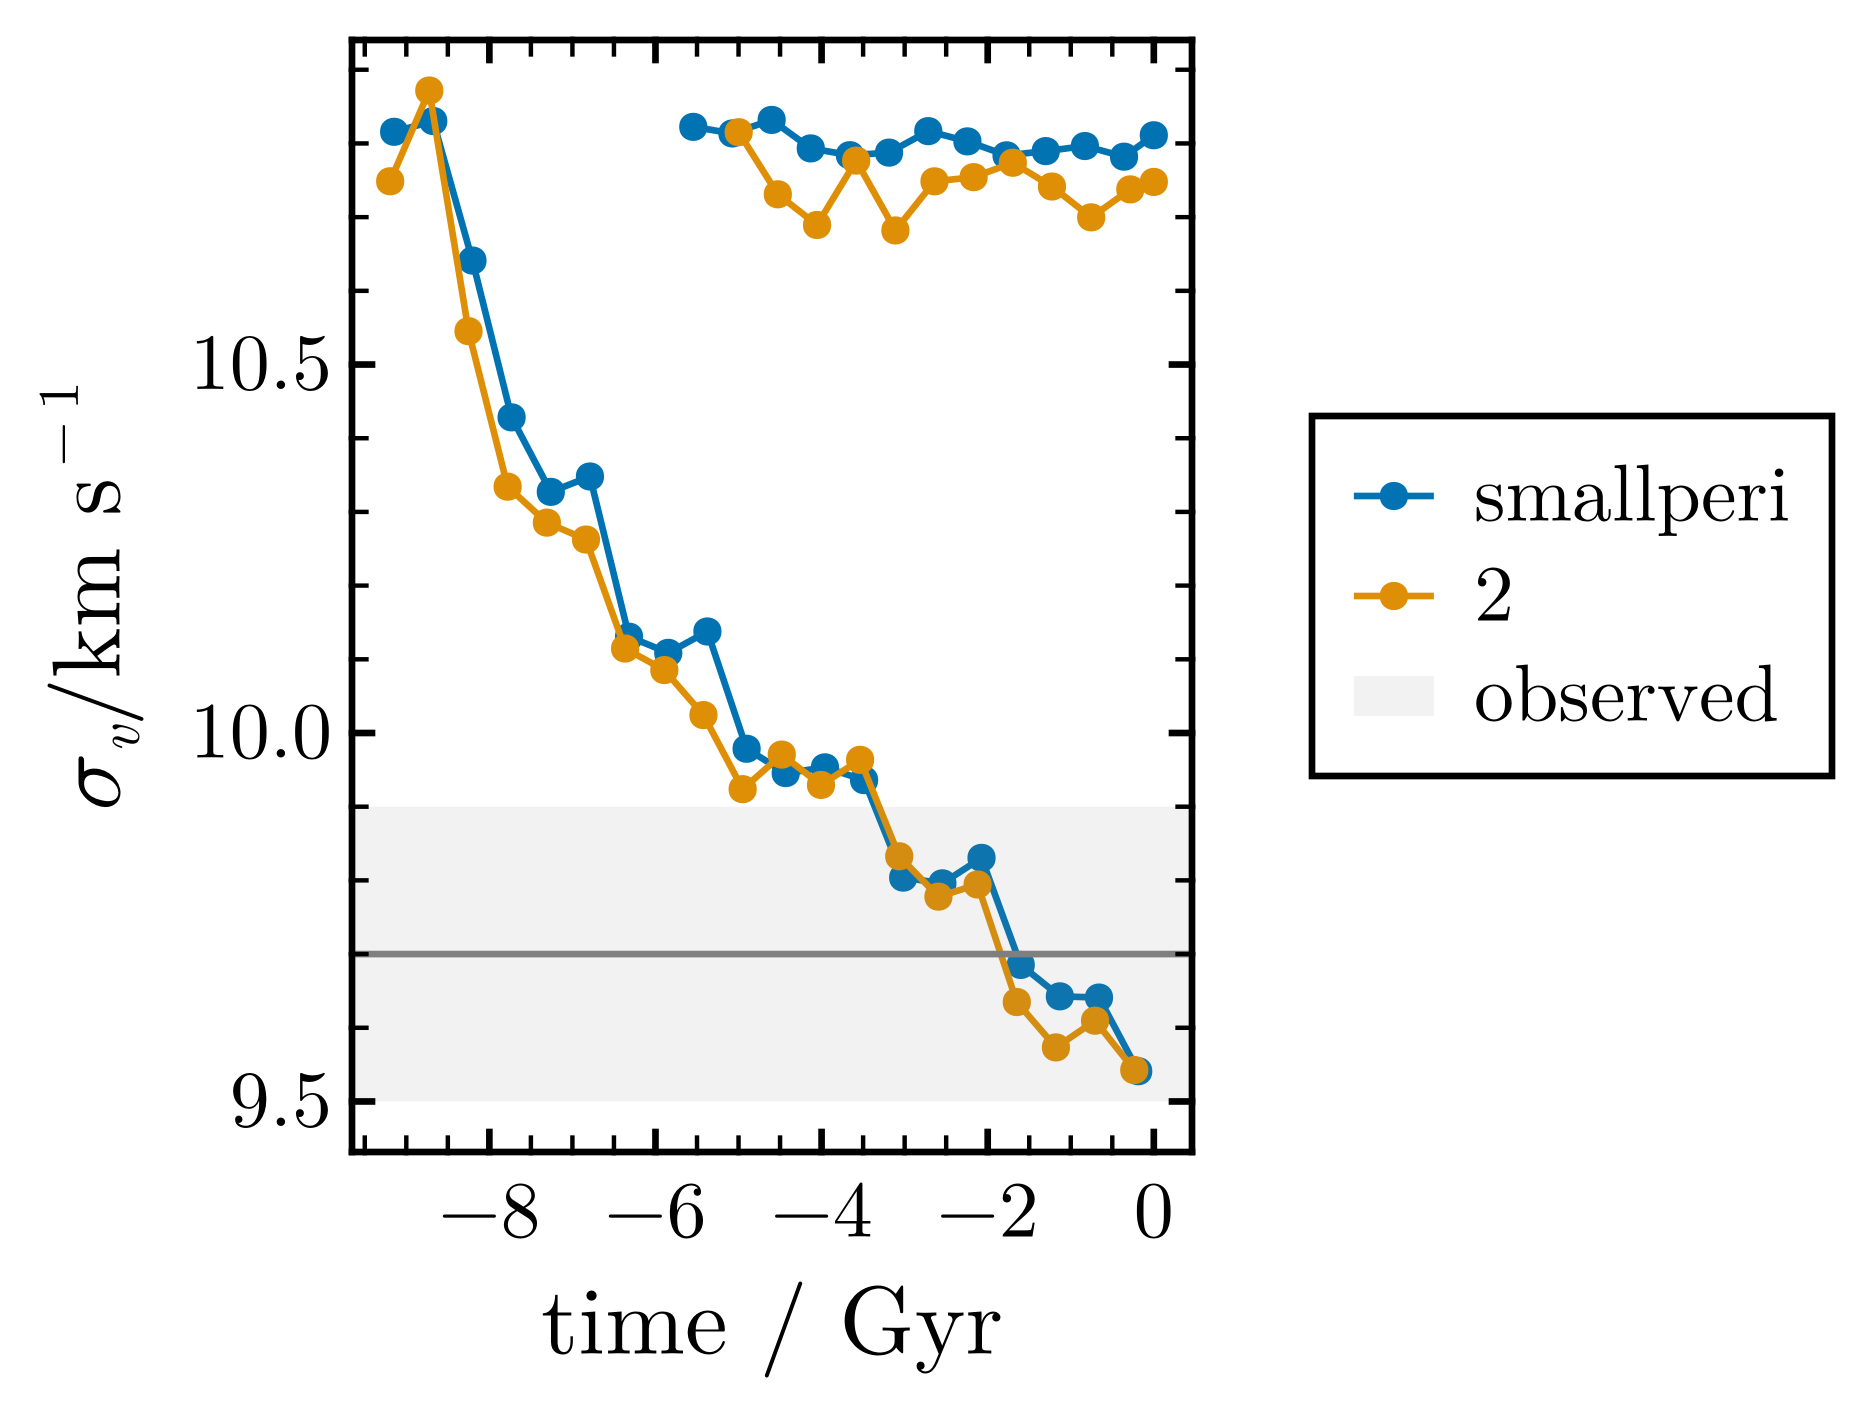

In [48]:
compare_v_t(profs, profs_iso, legend_position=:outside)

In [50]:
profs, profs_iso = load_both(
    ["mean" => ("1e7_V31_r3.2/orbit_mean", "exp2d_rs0.13"),
    "2" => ("1e6_new_v31_r3.2/orbit_mean", "exp2d_rs0.13"),
        ]
    );

[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened
[ Info: astropy table opened


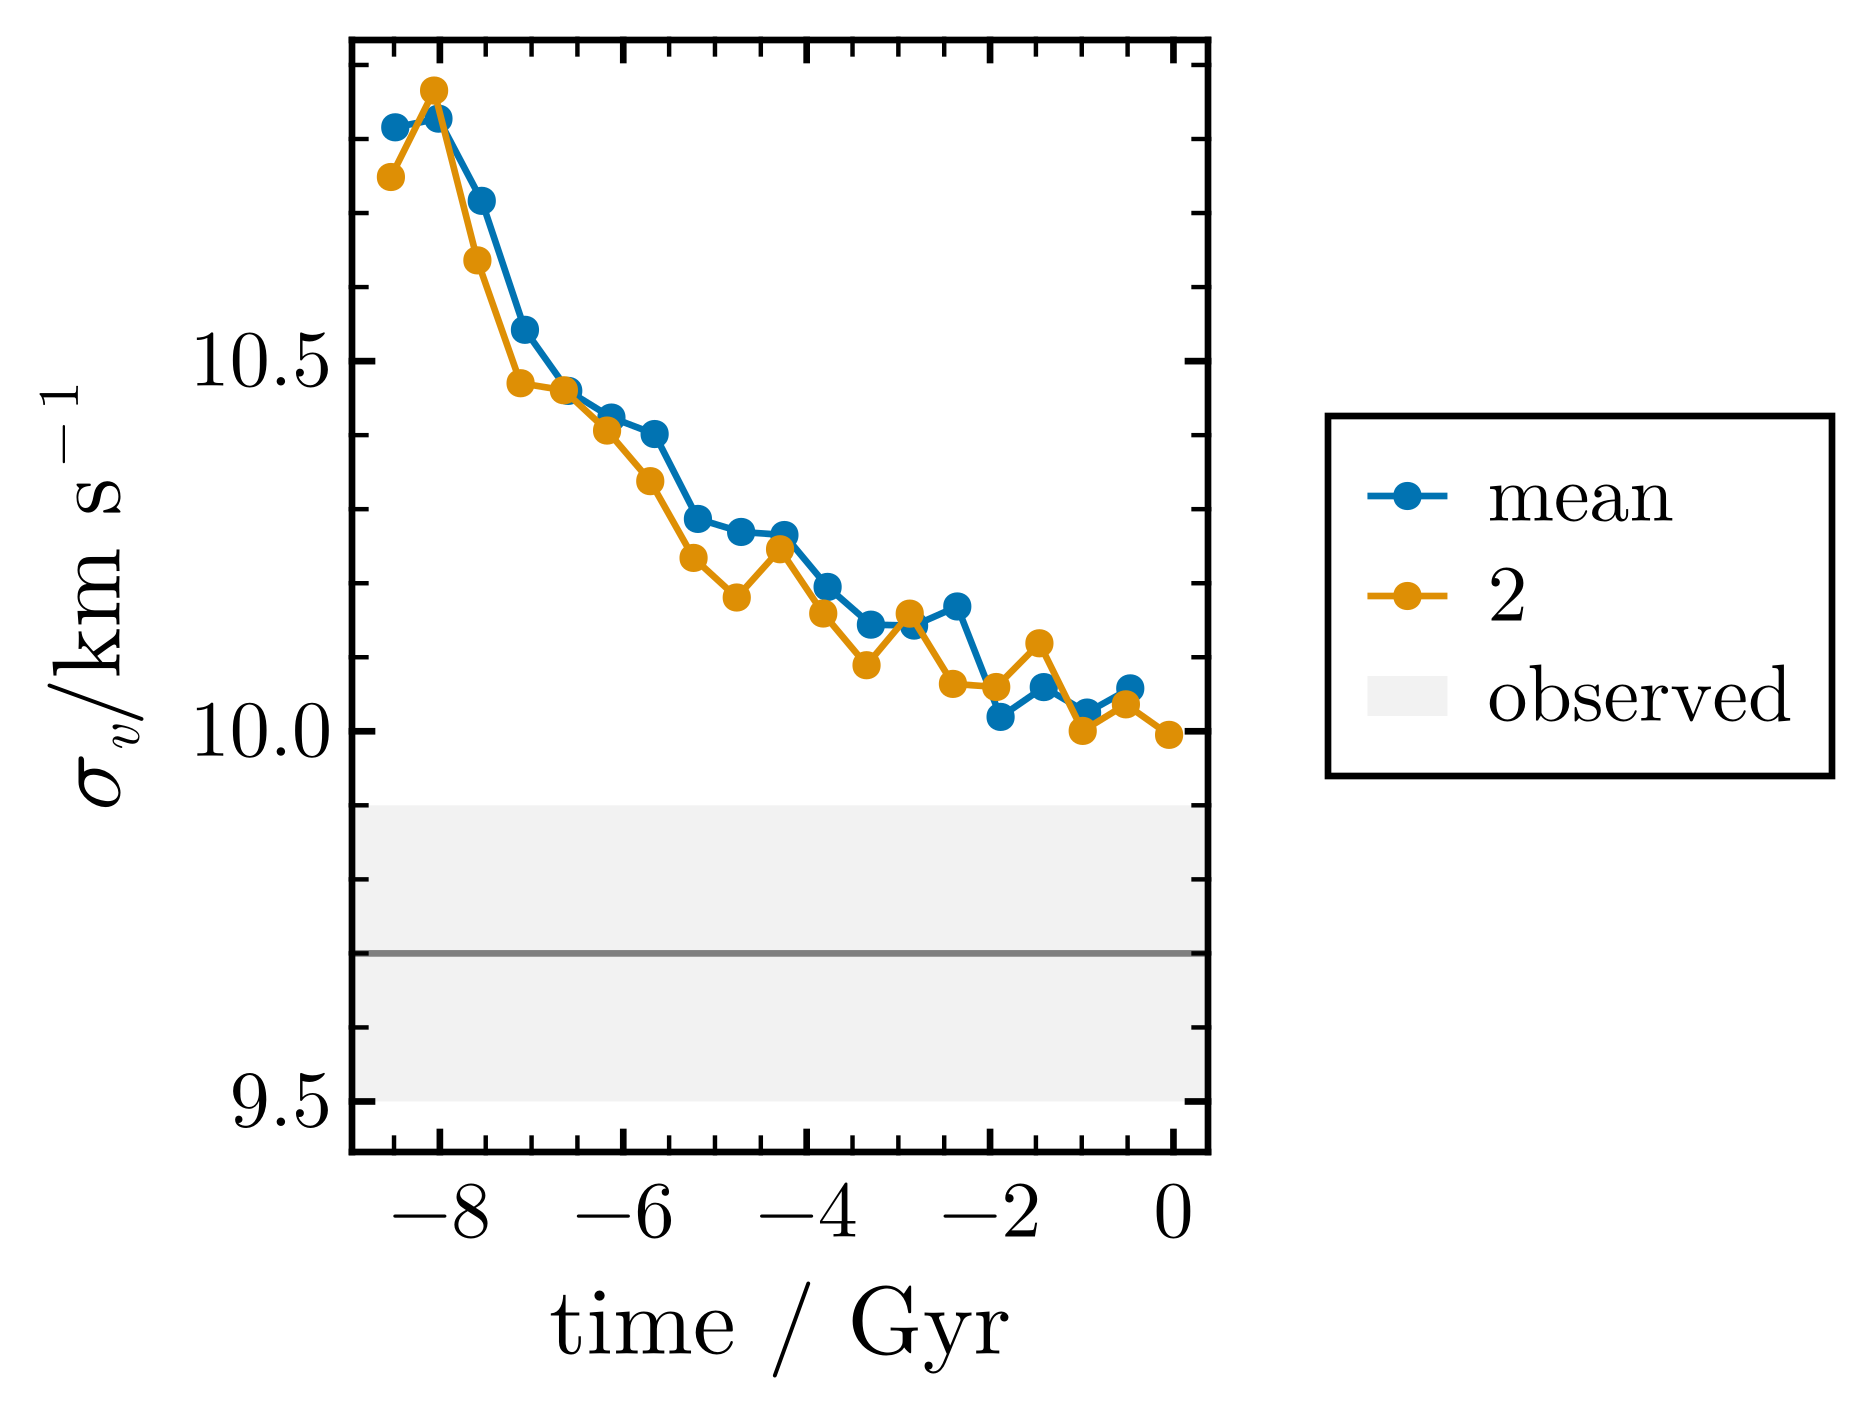

In [51]:
compare_v_t(profs, legend_position=:outside)